In [11]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [12]:
basedir = os.getcwd()
ds_basedir = os.path.abspath("/mnt/traffic/maruokai/datasets")
if not os.path.isdir('results'):
    os.mkdir('results')
out_path = os.path.join(basedir, 'results')

In [13]:
myseed = 2021  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # 
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)

In [14]:
transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
    #                              ratio=(1.0, 1.0)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),  # 依照概率p=0.5水平翻转
    transforms.RandomGrayscale(),       # 依照概率p=0.5转化为灰度图
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010])
    ])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

batch_size = 128
ratio = 0.2

# 读取数据集
dataset = torchvision.datasets.CIFAR10(
    root=ds_basedir, train=True, download=False, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root=ds_basedir, train=False, download=False, transform=transform_test)

val_num = int(len(dataset)*ratio)
train_num = int(len(dataset)-val_num)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_num, val_num])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print(f"Train dataset size = {len(train_dataset)}, batch num = {len(train_loader)}")
print(f"Val dataset size = {len(val_dataset)}, batch num = {len(val_loader)}")
print(f"Test dataset size = {len(test_dataset)}, batch num = {len(test_loader)}")

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Train dataset size = 40000, batch num = 313
Val dataset size = 10000, batch num = 79
Test dataset size = 10000, batch num = 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128 128
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


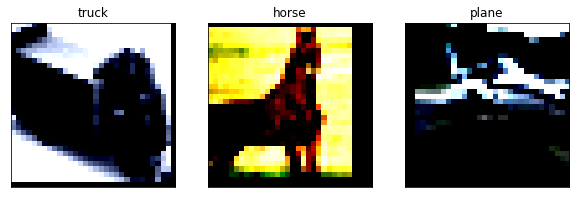

In [15]:
# 显示图片
def display(display_num=3, scale=10):
    cnt = 0
    fig,axes = plt.subplots(1, display_num, figsize=(1*scale, display_num*scale))
    axes = axes.flatten()
    images, labels = next(iter(train_loader))
    print(len(images), len(labels))
    for _, (image, label) in enumerate(zip(images, labels)):
        if cnt >= display_num:
            break
        #print(image.shape)
        image = image.numpy() # FloatTensor转为ndarray
        image = np.transpose(image, (1,2,0)) # 把channel放到最后，(h, w, channel)
        print(image.shape)
        ax = axes[cnt]
        ax.imshow(image)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(classes[label])
        cnt += 1
    fig.show()
display()

In [16]:
'''ResNet in PyTorch.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [17]:
def do_epoch(model, dataloader, criterion, optim=None):
    total_loss = 0
    total_correct = 0
    total_num = 0
    for x, y_true in tqdm(dataloader, leave=False):
        x, y_true = x.to(device), y_true.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()

        total_loss += loss.item()
        total_correct += (y_pred.argmax(dim=-1) == y_true).sum().item()
        total_num+=y_pred.size(0)
    mean_loss = 1.*total_loss / len(dataloader)
    mean_accuracy = 1.*total_correct / total_num

    return mean_loss, mean_accuracy

In [18]:
def train(num_epoch, model, criterion, optimizer, return_log = True):
    if return_log:
        train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
    best_acc = 0
    best_epoch = 0
    for epoch in range(1, num_epoch+1):
        model.train()
        train_loss, train_acc = do_epoch(model, train_loader, criterion, optim=optimizer)

        
        model.eval()
        val_loss, val_acc = do_epoch(model, val_loader, criterion, optim=None)
        if return_log:
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
    
        if (epoch%10==0):
            tqdm.write(f'EPOCH {epoch:03d}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f} 'f'val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            state = {
                'model': model.state_dict(),
                'acc': best_acc,
                'epoch': best_epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
    tqdm.write(f'best accuracy: {best_acc:.4f}, epoch: {best_epoch:03d}')
    if return_log:
        return train_loss_history, train_acc_history, val_loss_history, val_acc_history
    


In [19]:
def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0
    test_correct = 0
    total_num = 0
    for inputs, labels in tqdm(dataloader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss+=loss.item()
        test_correct+=(outputs.argmax(dim=-1) == labels).sum().item()
        total_num +=outputs.size(0)
    loss = 1.*test_loss/len(test_loader)
    acc = 1.*test_correct/total_num

    print(f"loss = {loss:.5f}, acc = {acc:.5f}")



In [20]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = ResNet34()
model = model.to(device)
num_epoch = 100
lr = 1e-2
best_acc = 0
best_epoch = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
if device=='cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(num_epoch, model, criterion, optimizer, True)


cuda


EPOCH 010: train_loss=0.3887, train_accuracy=0.8668 val_loss=0.4715, val_accuracy=0.8423


EPOCH 020: train_loss=0.2179, train_accuracy=0.9259 val_loss=0.3631, val_accuracy=0.8827


EPOCH 030: train_loss=0.1502, train_accuracy=0.9480 val_loss=0.3850, val_accuracy=0.8804


EPOCH 040: train_loss=0.1063, train_accuracy=0.9628 val_loss=0.3961, val_accuracy=0.8861


EPOCH 050: train_loss=0.0861, train_accuracy=0.9702 val_loss=0.3522, val_accuracy=0.9008


EPOCH 060: train_loss=0.0738, train_accuracy=0.9744 val_loss=0.3545, val_accuracy=0.9038


EPOCH 070: train_loss=0.0632, train_accuracy=0.9782 val_loss=0.3634, val_accuracy=0.8996


EPOCH 080: train_loss=0.0609, train_accuracy=0.9797 val_loss=0.3931, val_accuracy=0.8960


EPOCH 090: train_loss=0.0551, train_accuracy=0.9819 val_loss=0.3815, val_accuracy=0.8981


EPOCH 100: train_loss=0.0566, train_accuracy=0.9807 val_loss=0.3848, val_accuracy=0.9013
best accuracy: 0.9113, epoch: 095


In [21]:
np.save(os.path.join(out_path, 'train_acc_history_lr_'+str(lr)+'.npy'), train_acc_history)
np.save(os.path.join(out_path, 'train_loss_history_lr_'+str(lr)+'.npy'), train_loss_history)
np.save(os.path.join(out_path, 'val_acc_history_lr_'+str(lr)+'.npy'), val_acc_history)
np.save(os.path.join(out_path, 'val_loss_history_lr_'+str(lr)+'.npy'), val_loss_history)

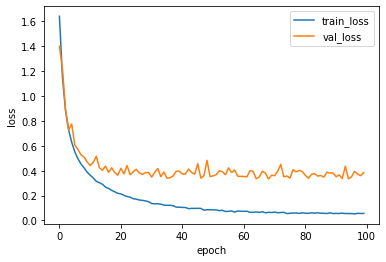

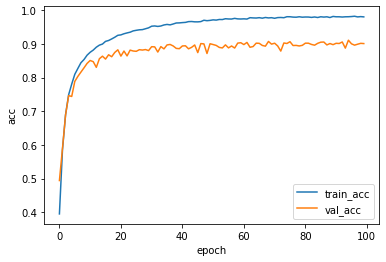

In [23]:
plt.figure()
plt.plot(range(len(train_loss_history)), train_loss_history, label='train_loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(out_path, 'loss.png'))

plt.figure()
plt.plot(range(len(train_acc_history)), train_acc_history, label='train_acc')
plt.plot(range(len(val_acc_history)), val_acc_history, label='val_acc')

plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(out_path, 'acc.png'))

np.save(os.path.join(out_path, 'train_loss_history.npy'), train_loss_history)
np.save(os.path.join(out_path, 'train_acc_history.npy'), train_acc_history)
np.save(os.path.join(out_path, 'val_loss_history.npy'), val_loss_history)
np.save(os.path.join(out_path, 'val_acc_history.npy'), val_acc_history)

In [24]:
if os.path.isdir('checkpoint'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'], False)
    best_acc = checkpoint['acc']
    best_epoch = checkpoint['epoch']
test(model, test_loader, criterion)

loss = 0.34433, acc = 0.91230
